<a href="https://colab.research.google.com/github/yustinaivanova/netology_statistics/blob/master/temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лекция 4. Кейс-стади. Классификационные задачи.

In [0]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
from sklearn.metrics import classification_report

%matplotlib inline


Загрузим датасет 'Faulty-steel-plates' с kaggle: (ссылка - https://www.kaggle.com/uciml/faulty-steel-plates)

In [2]:
import io
import requests
url="http://yustiks.ru/faults.csv"
dataset_temp=pd.read_csv(url) 
dataset_temp.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


В данном датасете 34 атрибута. Первые 27 атрибутов описывают некоторые несиправности стальной платы, которые были замечены в изображениях.

*    X_Minimum
*   X_Maximum
*    Y_Minimum
*    Y_Maximum
*    Pixels_Areas
*    X_Perimeter
*    Y_Perimeter
*    Sum_of_Luminosity
*    Minimum_of_Luminosity
*    Maximum_of_Luminosity
*    Length_of_Conveyer
*    TypeOfSteel_A300
*    TypeOfSteel_A400
*    Steel_Plate_Thickness
*    Edges_Index
*    Empty_Index
*    Square_Index
*    Outside_X_Index
*    Edges_X_Index
*    Edges_Y_Index
*    Outside_Global_Index
*    LogOfAreas
*    Log_X_Index
*    Log_Y_Index
*    Orientation_Index
*    Luminosity_Index
*    SigmoidOfAreas

Последние 7 колонок - это класс, к которому относится то или иное повреждение (one-hot-encoding). Например, если какой-либо элемент классифицируется как "Stains" (пятна), то в колонке 'Stains' 
будет стоять единица. Последние 7 атрибутов представляют собой класс для каждого элемента.

*    Pastry
*    Z_Scratch
*    K_Scatch
*    Stains
*    Dirtiness
*    Bumps
*    Other_Faults


Первые 27 колонок данной таблицы являются колонками для предсказаний класса.


In [3]:
data = dataset_temp.iloc[:,:27]
data[:4]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212



Посмотрим частотный график данных колонок (график histograms):

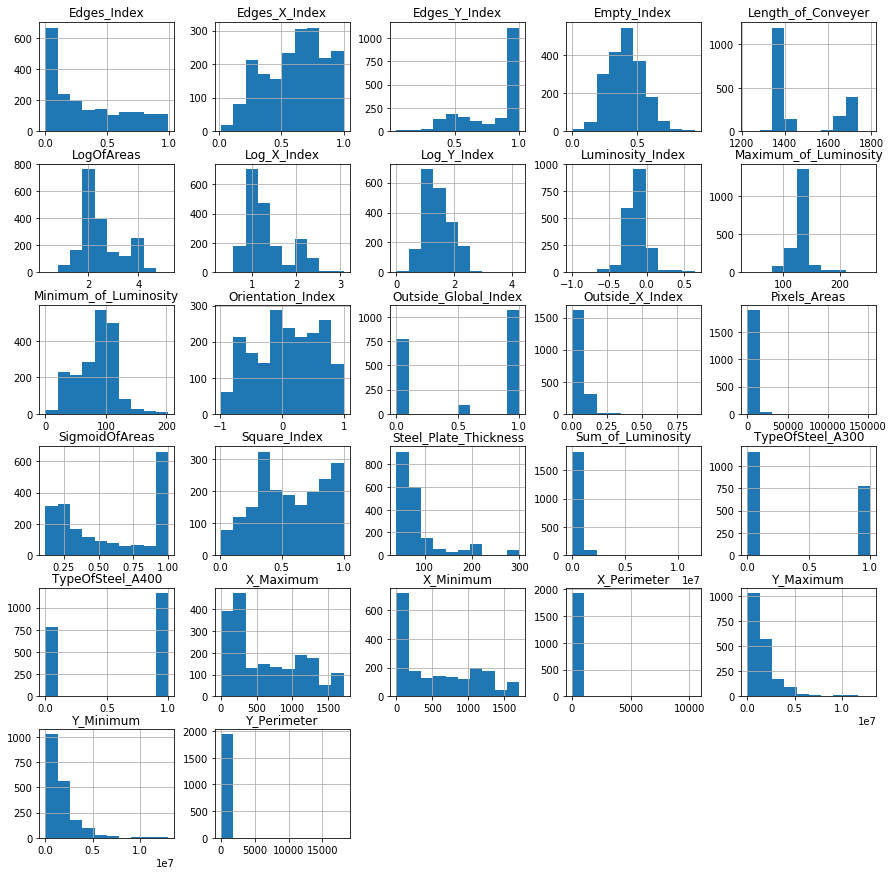

In [4]:
data.hist(figsize=(15,15))
plt.show()


Из данных графиков можно увидеть, что Outside_Global_Index, TypeOfSteel_A300, TypeOfSteel_A400 являются дискретными величинами со значениями [0, 0.5, 1], [0,1], [0,1] соответственно (распределение Бернулли).

Можно также заметить, что такие переменные, как Empty_Index, Log_Y_Index, Luminosity_Index являются нормальным распределением Гаусса.

Выделим колонки в отдельный список

In [0]:
headers = list(data.columns.values)

Нормализуем параметры

In [6]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

np_scaled = min_max_scaler.fit_transform(data)
df_norm = pd.DataFrame(np_scaled)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,-0.950733,-0.946167,-0.959296,-0.959291,-0.996528,-0.997128,-0.995262,-0.995864,-0.251232,-0.342593,0.622575,1.0,-1.0,-0.692308,-0.899920,-0.488293,-0.650096,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.242832,-0.609987,-0.609985,-0.998611,-0.998468,-0.996805,-0.998077,-0.172414,-0.203704,0.622575,1.0,-1.0,-0.692308,0.536777,-0.196313,-0.599476,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.027501,-0.761620,-0.761619,-0.999096,-0.998851,-0.998017,-0.998668,-0.024631,-0.185185,0.396825,1.0,-1.0,-0.538462,0.951367,-0.274076,-0.344560,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,0.001755,-0.944125,-0.944120,-0.997720,-0.997894,-0.995152,-0.996765,-0.024631,-0.175926,-0.555556,-1.0,1.0,0.923077,0.464429,-0.064943,-0.702934,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,0.523698,-0.924294,-0.924257,-0.968464,-0.988896,-0.971462,-0.957437,-0.635468,-0.175926,-0.555556,-1.0,1.0,0.115385,-0.860330,-0.049476,-0.883231,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


При нормализации стираются названия колонок, поэтому необходимо восстановить их:

In [7]:
df_norm.columns = headers
df_norm.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-0.950733,-0.946167,-0.959296,-0.959291,-0.996528,-0.997128,-0.995262,-0.995864,-0.251232,-0.342593,0.622575,1.0,-1.0,-0.692308,-0.899920,-0.488293,-0.650096,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.242832,-0.609987,-0.609985,-0.998611,-0.998468,-0.996805,-0.998077,-0.172414,-0.203704,0.622575,1.0,-1.0,-0.692308,0.536777,-0.196313,-0.599476,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.027501,-0.761620,-0.761619,-0.999096,-0.998851,-0.998017,-0.998668,-0.024631,-0.185185,0.396825,1.0,-1.0,-0.538462,0.951367,-0.274076,-0.344560,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,0.001755,-0.944125,-0.944120,-0.997720,-0.997894,-0.995152,-0.996765,-0.024631,-0.175926,-0.555556,-1.0,1.0,0.923077,0.464429,-0.064943,-0.702934,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,0.523698,-0.924294,-0.924257,-0.968464,-0.988896,-0.971462,-0.957437,-0.635468,-0.175926,-0.555556,-1.0,1.0,0.115385,-0.860330,-0.049476,-0.883231,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


In [8]:
len(df_norm)

1941

Построим матрицу корреляций:

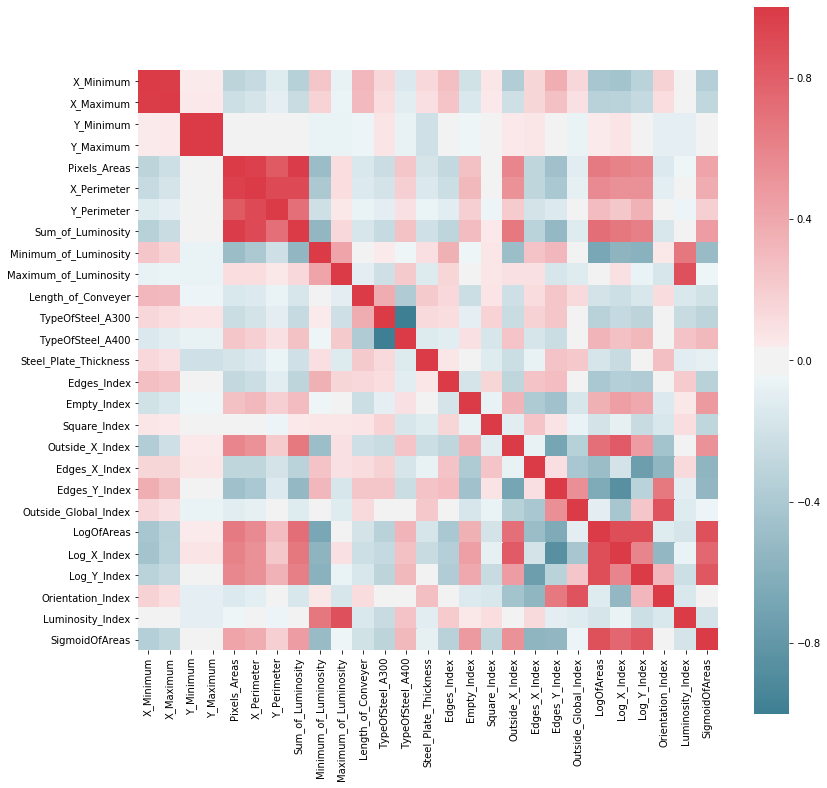

In [9]:
f, ax = plt.subplots(figsize=(13, 13))
corr = df_norm.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Некоторые переменные сильно коррелированы (например, Sum_of_Luminosity и Pixels_areas)

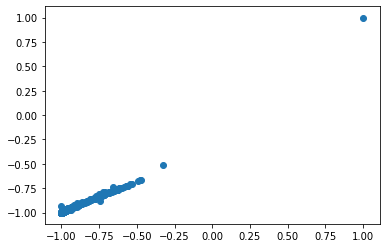

In [10]:
plt.scatter(df_norm['Sum_of_Luminosity'], df_norm['Pixels_Areas'])
plt.show()

Корреляция Пирсона

In [11]:
from scipy.stats import pearsonr
pearsonr(df_norm['Sum_of_Luminosity'], df_norm['Pixels_Areas'])

(0.9789516167596556, 0.0)

Удалим из таблицы значения с корреляцией, большей чем 95%: некоторые атрибуты имеют сильную корреляцию с другими атрибутами, нет смысла использовать два атрибута совместно.

In [12]:
# создаем матрицу корреляций
corr_matrix = df_norm.corr().abs()

# Выбираем верхний треугольник матрицы
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Ищем индексы колонок с корреляцией большей чем 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

['X_Maximum', 'Y_Maximum', 'X_Perimeter', 'Sum_of_Luminosity', 'TypeOfSteel_A400']


Удаляем колонки, которые не нужны:

In [13]:
df_norm = df_norm.drop(df_norm[to_drop], axis=1)
df_norm.head()

,X_Minimum,Y_Minimum,Pixels_Areas,Y_Perimeter,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-0.950733,-0.959296,-0.996528,-0.995262,-0.251232,-0.342593,0.622575,1.0,-0.692308,-0.899920,-0.488293,-0.650096,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.609987,-0.998611,-0.996805,-0.172414,-0.203704,0.622575,1.0,-0.692308,0.536777,-0.196313,-0.599476,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.761620,-0.999096,-0.998017,-0.024631,-0.185185,0.396825,1.0,-0.538462,0.951367,-0.274076,-0.344560,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,-0.944125,-0.997720,-0.995152,-0.024631,-0.175926,-0.555556,-1.0,0.923077,0.464429,-0.064943,-0.702934,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,-0.924294,-0.968464,-0.971462,-0.635468,-0.175926,-0.555556,-1.0,0.115385,-0.860330,-0.049476,-0.883231,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


После удаления остается 22 колонки:

In [14]:
df_norm.shape

(1941, 22)

Посмотреть разбиение по классам. Сколько элементов в каждом классе?

Pastry	Z_Scratch	K_Scatch	Stains	Dirtiness	Bumps	Other_Faults

In [15]:
print('Количество значений 1го класса: ', dataset_temp[dataset_temp['Pastry']==1].shape)
print('Количество значений 2го класса: ', dataset_temp[dataset_temp['Z_Scratch']==1].shape)
print('Количество значений 3го класса: ', dataset_temp[dataset_temp['K_Scatch']==1].shape)
print('Количество значений 4го класса: ', dataset_temp[dataset_temp['Stains']==1].shape)
print('Количество значений 5го класса: ', dataset_temp[dataset_temp['Dirtiness']==1].shape)
print('Количество значений 6го класса: ', dataset_temp[dataset_temp['Bumps']==1].shape)
print('Количество значений 7го класса: ', dataset_temp[dataset_temp['Other_Faults']==1].shape)


Количество значений 1го класса:  (158, 34)
Количество значений 2го класса:  (190, 34)
Количество значений 3го класса:  (391, 34)
Количество значений 4го класса:  (72, 34)
Количество значений 5го класса:  (55, 34)
Количество значений 6го класса:  (402, 34)
Количество значений 7го класса:  (673, 34)


Количество элементов в каждом классе отличается.

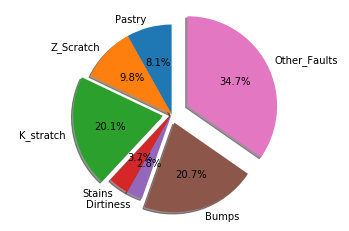

In [16]:
# Построем pie-график
labels = 'Pastry', 'Z_Scratch', 'K_stratch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'
sizes = [158, 190, 391, 72, 55, 402, 673]
explode = (0, 0, 0.1, 0, 0, 0.1, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Так как есть несбалансированность классов, необходимо уравнять количество элементов в каждом классе засчет **генерирования новых (up-sampling)** или **удаления элементов (down-sampling)**.

С проблемой классификации с несбалансированными данными хорошо работает метод решения деревьев.

In [0]:
output_y = dataset_temp.iloc[:,27:]
#input_x = dataset_temp.iloc[:,:27]
input_x = df_norm

Таргет значение представим ввиде наименований классов.

In [18]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
dtype: int64


Выделим из датасета тренировочные и тестовые данные. 
Тренировочные данные будем использовать для обучения модели.
Тестовые данные будем использовать для подсчета качества модели.

In [0]:
from sklearn.model_selection import train_test_split
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(input_x, Y, test_size=0.3)

No handles with labels found to put in legend.


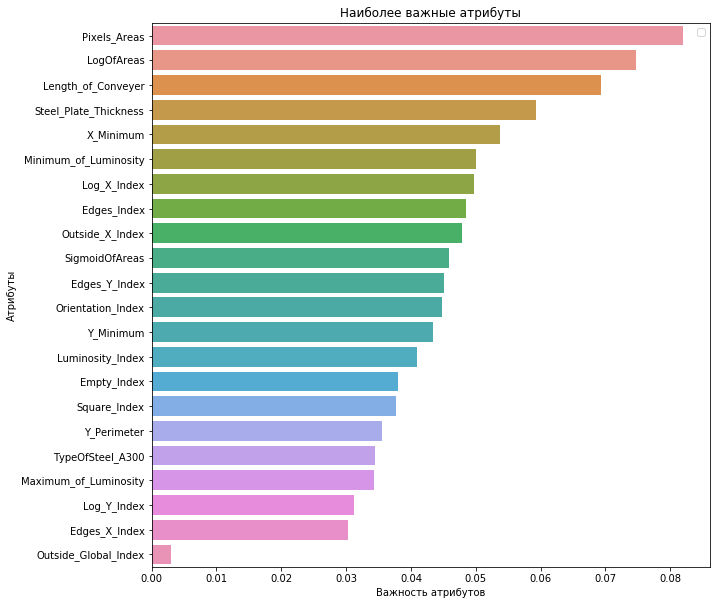

In [20]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train_22,y_train_22)

headers = list(X_train_22.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Посчитаем качество модели:

In [21]:
model_pred = model.predict(X_test_22)

print(classification_report(y_test_22, model_pred))

model.score(X_test_22, y_test_22)

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       124
           1       0.82      0.82      0.82        17
           2       0.96      0.98      0.97       102
           3       0.66      0.77      0.71       212
           4       0.55      0.46      0.50        48
           5       0.94      0.76      0.84        21
           6       0.96      0.75      0.84        59

    accuracy                           0.74       583
   macro avg       0.79      0.73      0.76       583
weighted avg       0.75      0.74      0.74       583



0.7409948542024014

Модель "рандомных деревьев" дала точность предсказания порядка 77%.

Мы можем сравнить с теми атрибутами, которые мы удалили, отсекая 10% максимально коррелированных элементов:

In [22]:
['X_Maximum', 'Y_Maximum', 'X_Perimeter', 'Sum_of_Luminosity', 'TypeOfSteel_A400']

['X_Maximum',
 'Y_Maximum',
 'X_Perimeter',
 'Sum_of_Luminosity',
 'TypeOfSteel_A400']

Получается, мы не удалили наиболее важные элементы для деревьев решений => хороший признак.

Можно отобразить классы (их всего 7) в 3D пространстве наиболее важных векторов (Length_of_Conveyer, Outside_X_Index, Log_X_Index):

In [0]:
df = df_norm
df['target'] = Y

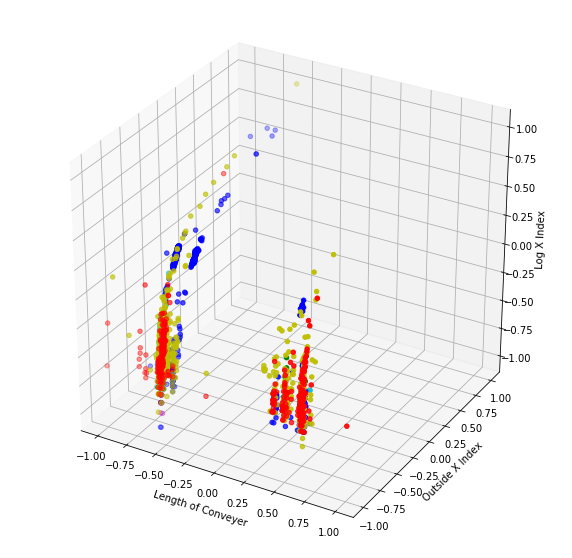

In [24]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', 'y', 'b', 'm', '#17becf']

for i in range(7):
  
  a = df.loc[df['target'] == i, 'Length_of_Conveyer']
  b = df.loc[df['target'] == i, 'Outside_X_Index']
  c = df.loc[df['target'] == i, 'Log_X_Index']

  ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('Length of Conveyer')
ax.set_ylabel('Outside X Index')
ax.set_zlabel('Log X Index')
plt.show()

Можно также посмотреть распределение классов в 3D пространстве по другим атрибутам, например: 'Steel_Plate_Thickness', 'Edges_Index', 'Outside_Global_Index'

In [0]:
df = pd.DataFrame(input_x, columns = ['Steel_Plate_Thickness', 'Edges_Index', 'Outside_Global_Index'])
df['target'] = Y

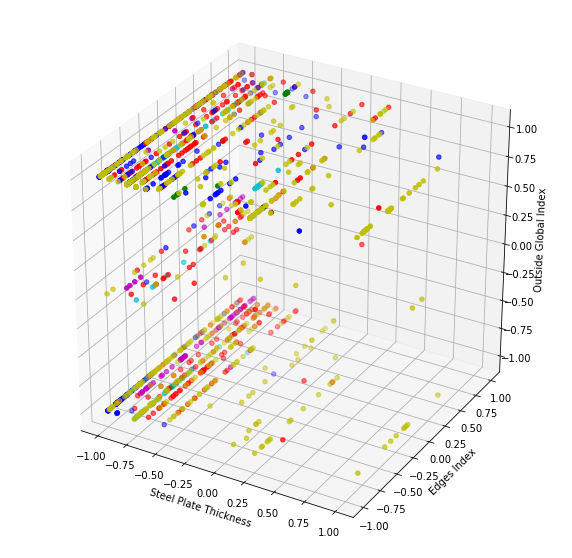

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', 'y', 'b', 'm', '#17becf']

for i in range(7):
  
  a = df.loc[df['target'] == i, 'Steel_Plate_Thickness']
  b = df.loc[df['target'] == i, 'Edges_Index']
  c = df.loc[df['target'] == i, 'Outside_Global_Index']

  ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('Steel Plate Thickness')
ax.set_ylabel('Edges Index')
ax.set_zlabel('Outside Global Index')
plt.show()

Как же уменьшить количество атрибутов, при этом оставив данные в пространстве таким образом, чтобы легко можно было классифицировать?

# Принцип минимальных компонент

Почитать про метод - https://ru.wikipedia.org/wiki/Метод_главных_компонент

Соответственно, было 23 атрибута

In [27]:
print(df_norm.shape)

(1941, 23)


Создаем модель PCA

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

In [0]:
principalComponents = pca.fit_transform(df_norm)
projected_x = pd.DataFrame(data = principalComponents,
                           columns = ['atribute_1', 'atribute_2', 'atribute_3'])


После применения PCA осталось только 3 атрибута

In [0]:
projected_x['target'] = Y

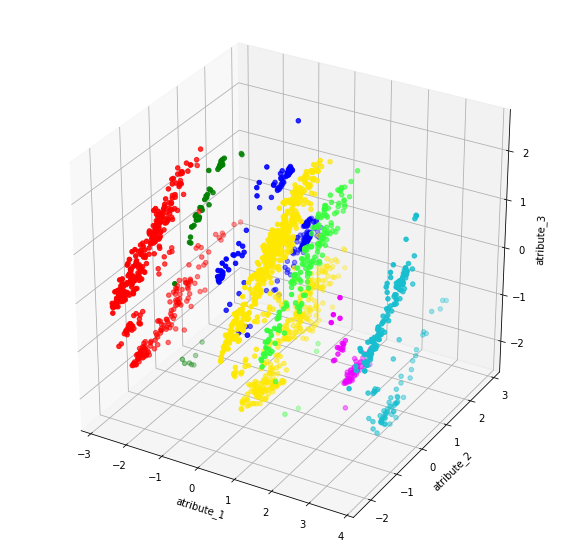

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', '#FFE800', '#33FF39', '#EC00FF', '#17becf']

for i in range(7):
    a = projected_x.loc[projected_x['target'] == i, 'atribute_1']
    b = projected_x.loc[projected_x['target'] == i, 'atribute_2']
    c = projected_x.loc[df['target'] == i, 'atribute_3']
    ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('atribute_1')
ax.set_ylabel('atribute_2')
ax.set_zlabel('atribute_3')
plt.show()

Классы расположены в пространстве так, что их можно идеально отличить друг от друга!

**Если бы данные не были нормированы, то мы получили бы совершенно другой результат!**

In [0]:
principalComponents = pca.fit_transform(dataset_temp.iloc[:,:27])
projected_x = pd.DataFrame(data = principalComponents,
                           columns = ['atribute_1', 'atribute_2', 'atribute_3'])
projected_x['target'] = Y

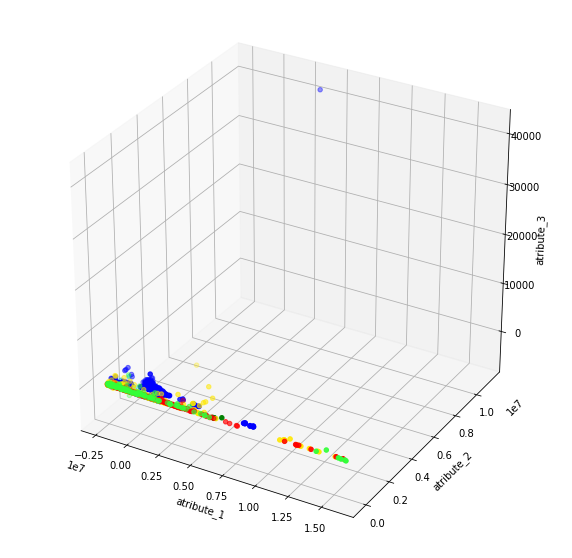

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', '#FFE800', '#33FF39', '#EC00FF', '#17becf']

for i in range(7):
    a = projected_x.loc[projected_x['target'] == i, 'atribute_1']
    b = projected_x.loc[projected_x['target'] == i, 'atribute_2']
    c = projected_x.loc[df['target'] == i, 'atribute_3']
    ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('atribute_1')
ax.set_ylabel('atribute_2')
ax.set_zlabel('atribute_3')
plt.show()

**Вывод:** при работае с методом минимальных компонент данные необходимо **нормировать**

# Методы работы с несбалансированными данными

Увеличим количество элементов в таблице для уравновешивания классов.

Будем использовать библиотеку imblearn

как установить в среде: https://imbalanced-learn.readthedocs.io/en/stable/install.html

Создадим тренировочный и тестовый датасет из исходных данных

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_norm,
                                                 Y,
                                                 test_size = 0.3,#%70 train, 30% test
                                                 random_state = 3)

Увеличим количество тренировочных данных (тестовые данные остаются нетронутыми)

In [35]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomOverSampler(random_state=0)

ros.fit(X_train, y_train)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
print('Количество элементов до операции:', len(X_train))
print('Количество элементов после операции:', len(X_resampled))

Количество элементов до операции: 1358
Количество элементов после операции: 3248


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Мы увеличили количество элементов, и уравняли классы по количеству

In [36]:
unique, counts = np.unique(y_resampled, return_counts=True)
dict(zip(unique, counts))

{0: 464, 1: 464, 2: 464, 3: 464, 4: 464, 5: 464, 6: 464}

Но в тестовых данных остается несбалансированность

In [37]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 117, 1: 16, 2: 102, 3: 209, 4: 53, 5: 19, 6: 67}

# Мультиклассовая логистическая регрессия

Применим алгоритм логистической регрессии:

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       117
           1       0.93      0.81      0.87        16
           2       0.88      0.97      0.92       102
           3       0.88      0.90      0.89       209
           4       0.86      0.60      0.71        53
           5       1.00      1.00      1.00        19
           6       0.96      1.00      0.98        67

    accuracy                           0.92       583
   macro avg       0.93      0.90      0.91       583
weighted avg       0.92      0.92      0.91       583



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Если бы данные были **не нормированы**

In [0]:
input_x = dataset_temp.iloc[:,:27]
input_x = input_x.drop(input_x[to_drop], axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(dataset_temp.iloc[:,:27],
                                                 Y,
                                                 test_size = 0.3,#%70 train, 30% test
                                                 random_state = 3)

In [41]:
ros = RandomOverSampler(random_state=0)

ros.fit(X_train, y_train)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
print('Количество элементов до операции:', len(X_train))
print('Количество элементов после операции:', len(X_resampled))

Количество элементов до операции: 1358
Количество элементов после операции: 3248


In [42]:
model = LogisticRegression()
model.fit(X_train, y_train)

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.45      0.15      0.23       117
           1       0.00      0.00      0.00        16
           2       0.87      0.81      0.84       102
           3       0.44      0.90      0.59       209
           4       0.00      0.00      0.00        53
           5       0.93      0.74      0.82        19
           6       0.00      0.00      0.00        67

    accuracy                           0.52       583
   macro avg       0.38      0.37      0.35       583
weighted avg       0.43      0.52      0.43       583



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Все очень плохо. 44% точности всего

# Модель Random Forest на сгенерированных данных

In [43]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_resampled, y_resampled)

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       117
           1       0.87      0.81      0.84        16
           2       0.96      0.94      0.95       102
           3       0.74      0.77      0.75       209
           4       0.71      0.47      0.57        53
           5       0.95      0.95      0.95        19
           6       0.91      0.91      0.91        67

    accuracy                           0.79       583
   macro avg       0.83      0.80      0.81       583
weighted avg       0.79      0.79      0.79       583



Почему-то модель Random Forest показала результат не лучше, чем модель логистической регрессии.

# Пример кросс-валидации

Разделим датасет на 10 частей, предварительно перемешав все элементы между собой.

Будем проверять качество логистической регрессии с помощью кросс-валидации

In [0]:
shuffled = df_norm
shuffled = shuffled.sample(frac=1)
shuffled = shuffled.reset_index(drop=True)

In [45]:
from sklearn import metrics

part = len(shuffled)//10

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

mean_score = 0
for i in range(10):
    test = shuffled[i*part:(i+1)*part]
    train = shuffled.drop(shuffled.index[i*part:(i+1)*part])
    # обучаем модель
    train_x = train.drop(['target'], axis=1)
    train_y = train.target
    test_x = test.drop(['target'], axis=1)
    test_y = test.target
    model.fit(train_x, train_y)

    model_pred = model.predict(test_x)
    mean_score += metrics.accuracy_score(test_y, model_pred)
    
print(mean_score/10)

0.7804123711340206


Кросс-валидация показала, что точность алгоритма деревьев решений 78%

# Кривая ROC-Curve

Загрузим датасет ирисов

In [46]:
url='http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')), header=None, names=["Sepal length", "Sepal width", "Petal length", "Petal width", 'species'])
data.head()

,Sepal length,Sepal width,Petal length,Petal width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Имеется 3 класса ирисов. Это многоклассовая проблема. Преобразуем данные в one-hot encoding:
каждый тип цветка будет представлен ввиде вектора длины 3 (1ый элемент - цветок iris-setosa, 2ой элемент - цветок iris-versicolor, 3-й - iris-virginica).

In [47]:
# преобразуем колонку species в one-hot encoding вектор
one_hot = pd.get_dummies(data['species'])
# Удаляем колонку species
data = data.drop('species',axis = 1)
# добавляем колонку one-hot к исходной таблице
data = data.join(one_hot)
data.head()

,Sepal length,Sepal width,Petal length,Petal width,Iris-setosa,Iris-versicolor,Iris-virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


теперь каждая колонка (iris-setosa, iris-versicolor, iris-virginica) - это отдельная классификационная задача.
Допустим, мне нужно предсказать, является ли данный элемент iris-setosa видом.

In [0]:
X_df = data[['Sepal length', 'Sepal width', 'Petal length', 'Petal width']]
X = np.array(data[['Sepal length', 'Sepal width', 'Petal length', 'Petal width']])
Y = np.array(data['Iris-setosa']).astype(int)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

Допустим, мы используем модель Catboost (без нормирования данных) - https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html

Установить catboost в google colab

In [50]:
!pip install catboost

0:	learn: 0.3748817	total: 78.2ms	remaining: 313ms
1:	learn: 0.2206017	total: 80.8ms	remaining: 121ms
2:	learn: 0.1211816	total: 81.6ms	remaining: 54.4ms
3:	learn: 0.0979098	total: 86ms	remaining: 21.5ms
4:	learn: 0.0687124	total: 86.6ms	remaining: 0us


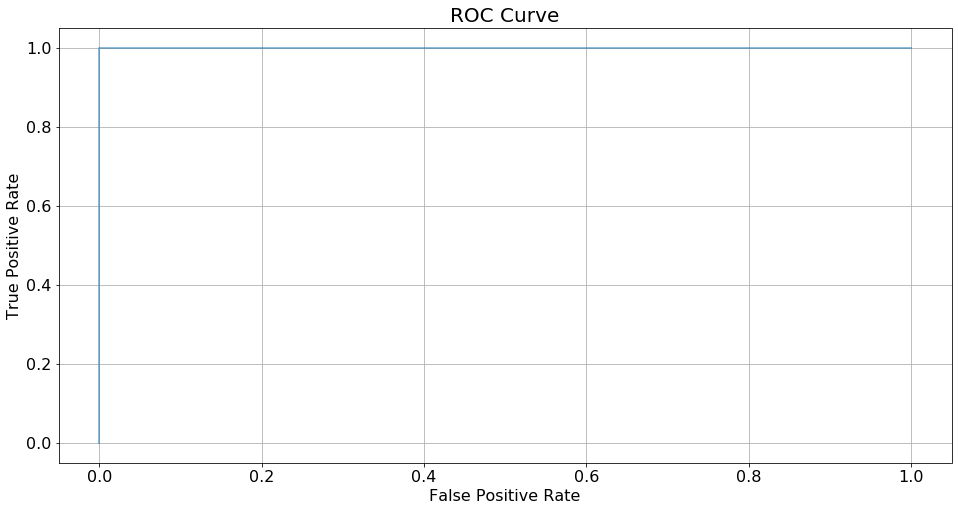

In [51]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

# создаем все атрибуты таблицы
cat_features = np.where(X_df.dtypes != np.float)[0]
train_data = X_train
train_labels = y_train
eval_data = X_test
catboost_pool = Pool(train_data, train_labels)

model = CatBoostClassifier(iterations=5,
                           learning_rate=1,
                           depth=16)
# обучаем модель
model.fit(train_data, train_labels, cat_features)
# получаем предсказания для классов
preds_class = model.predict(eval_data)

(fpr, tpr, thresholds) = get_roc_curve(model, catboost_pool, plot=True)

**Идеальный случай** - когда классификатор предсказывает со 100%-ой точностью

и действительно, если мы посмотрим classification report, так и есть:

In [52]:
print(classification_report(y_test, preds_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        17

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



Ну что ж, 100%-тное качество модели. Будем считать, что мы создали идеальную модели для датасета. 

# ROC-кривая датасет пациентов с сердечными болезнями

In [53]:
url="http://yustiks.ru/dataset/heart.csv"
data=pd.read_csv(url)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
X = data.drop('target', axis=1)
y = data.target

In [0]:
# разделим на тренировочные данные и на тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [0]:
model = LogisticRegression(solver='liblinear').fit(X_train, y_train)

В проблеме **классификации** модель предсказывает target значение, а также вероятность для данного класса. Отдельно вероятность предсказывается для каждого класса (их два в данном примерме: target 1 - человек здоров, target 0 -человек болен)

In [57]:
print('Предсказанный класс для тестовых данных (пациентов)')
print(model.predict(X_test))
print('Предсказанные вероятности для каждого класса (0 и 1 соответственно)')
print(model.predict_proba(X_test))

Предсказанный класс для тестовых данных (пациентов)
[0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1
 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0
 0 0]
Предсказанные вероятности для каждого класса (0 и 1 соответственно)
[[0.515715   0.484285  ]
 [0.07982885 0.92017115]
 [0.0271194  0.9728806 ]
 [0.40618651 0.59381349]
 [0.03320988 0.96679012]
 [0.08597297 0.91402703]
 [0.89910007 0.10089993]
 [0.010145   0.989855  ]
 [0.57240687 0.42759313]
 [0.77584873 0.22415127]
 [0.05829201 0.94170799]
 [0.33426127 0.66573873]
 [0.06972081 0.93027919]
 [0.99722092 0.00277908]
 [0.86390261 0.13609739]
 [0.25708703 0.74291297]
 [0.85293392 0.14706608]
 [0.09469168 0.90530832]
 [0.09615181 0.90384819]
 [0.42042577 0.57957423]
 [0.48833596 0.51166404]
 [0.98982109 0.01017891]
 [0.87062133 0.12937867]
 [0.98774165 0.01225835]
 [0.04858295 0.95141705]
 [0.10066321 0.89933679]
 [0.27962922 0.72037078]
 [0.72130887 0.27869113]
 [0.95878887 0.04121113]

In [58]:
!pip install scikit-plot

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


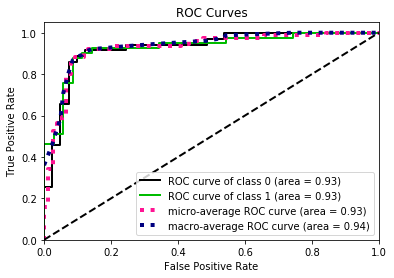

In [59]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_test
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

Text(0, 0.5, 'TPR')

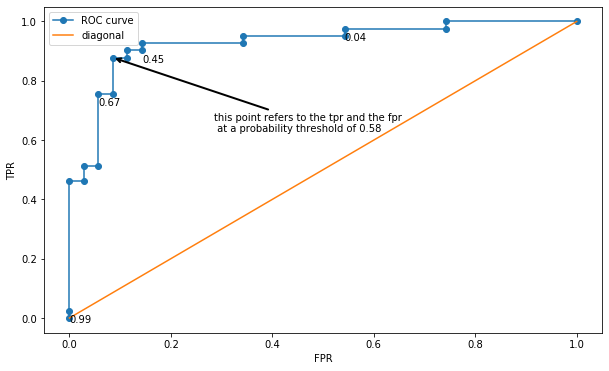

In [60]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas[:, 1])

# %%
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[1::5], tpr[1::5], thresholds[1::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 8
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

По графику получается, что можно отсекать все классы, вероятность предсказания которых (для target = 1) меньше 58%. 

# Рекурентная сеть для предсказания временных данных

Загрузим датасет "Цена на нефть" - https://www.kaggle.com/mabusalah/brent-oil-prices

In [0]:
import  datetime
#Convert date coulmns to specific format
dateparse = lambda x: pd.datetime.strptime(x, '%b %d, %Y')
#Read csv file
url="http://yustiks.ru/dataset/BrentOilPrices.csv"
df = pd.read_csv(url,parse_dates=['Date'], date_parser=dateparse)

#Sort dataset by column Date
df = df.sort_values('Date')
df = df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
df=df.loc[datetime.date(year=2000,month=1,day=1):]

In [62]:
# Print some data rows.
df.tail()

,Price
Date,
2019-09-24,64.13
2019-09-25,62.41
2019-09-26,62.08
2019-09-27,62.48
2019-09-30,60.99


# Будем предсказывать показания не на каждый месяц, а на начальный день каждого месяца


Сделаем resample данных на начало каждого месяца

Метод resample('..') может принимать следующие значения

```
B         business day frequency
C         custom business day frequency (experimental)
D         calendar day frequency
W         weekly frequency
M         month end frequency
SM        semi-month end frequency (15th and end of month)
BM        business month end frequency
CBM       custom business month end frequency
MS        month start frequency
SMS       semi-month start frequency (1st and 15th)
BMS       business month start frequency
CBMS      custom business month start frequency
Q         quarter end frequency
BQ        business quarter endfrequency
QS        quarter start frequency
BQS       business quarter start frequency
A         year end frequency
BA, BY    business year end frequency
AS, YS    year start frequency
BAS, BYS  business year start frequency
BH        business hour frequency
H         hourly frequency
T, min    minutely frequency
S         secondly frequency
L, ms     milliseconds
U, us     microseconds
N         nanoseconds
```

таким образом мы будем предсказывать только цену на начало месяца

In [0]:
y = df['Price'].resample('MS').mean()

In [64]:
y.tail()

Date
2019-05-01    71.317727
2019-06-01    64.220500
2019-07-01    63.919130
2019-08-01    59.041818
2019-09-01    62.826667
Freq: MS, Name: Price, dtype: float64

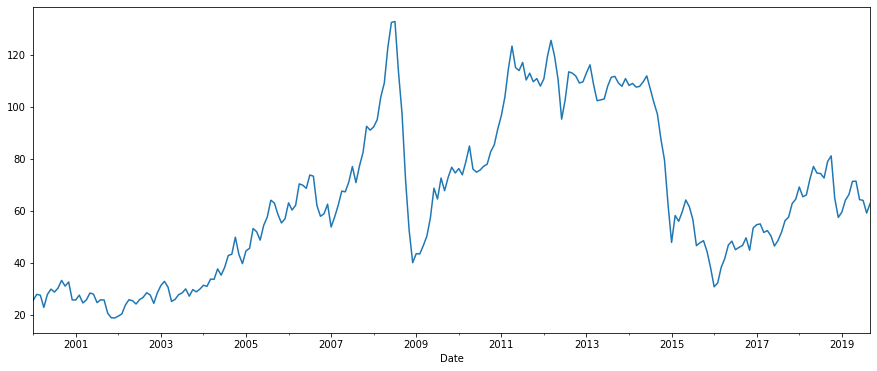

In [65]:
y.plot(figsize=(15, 6))
plt.show()

**Нормализуем данные**

In [0]:
# normalize the data_set 
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

In [67]:
df

array([[0.05838041],
       [0.05657564],
       [0.05524168],
       ...,
       [0.35758004],
       [0.36071877],
       [0.34902699]])

**Делим датасет на тренировочный и на тестовый**

In [0]:
# split into train and test sets
train_size = int(len(df) * 0.60)
valid_size = int(len(df) * 0.15)
test_size = len(df) - train_size - valid_size
train, valid, test = df[0:train_size, :], df[train_size:train_size+valid_size, :], df[train_size+valid_size:, :]

Есть еще валидационный датасет (для проверки, как обучилась модель на каждой эпохе)

**Создаем вектор из временных интервалов, с шагом = 1**

In [0]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [0]:
# reshape into X=t and Y=t+1
look_back =90
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_valid,Y_valid=create_data_set(valid, look_back)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [74]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# create and fit the LSTM network regressor = Sequential() 
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_valid, Y_valid), callbacks=[reduce_lr],shuffle=False)

RuntimeError: ignored

In [0]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [0]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [0]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();